# Quickstart Tutorial

`galtab` is a general approach for calculating the expectation value of
counts-in-cells statistics for a given halo catalog and HOD model. It pretabulates
placeholder galaxies inside each halo to yield rapid, deterministic results,
which is ideal for MCMC likelihood evaluations.

This [tutorial](https://github.com/AlanPearl/galtab/blob/main/docs/source/notebooks/intro.ipynb)
will demonstrate some basic Counts-in-Cylinders (CiC) calculations
using the intended `galtab` workflow.

To cite `galtab`, learn more implementation details, and explore an example science
use case, check out https://arxiv.org/abs/2309.08675.

## Prerequisites

All of the following are `pip` installable

- `galtab`
    - `numpy`
    - `jax`
    - `astropy`
    - `halotools`
- `matplotlib`
- `jupyterlab`

After installing the above *and downloading the bolplanck z=0 halotools catalog*,
you should be able to run the following cell. In this cell:

- set our cosmology and CiC parameters
- choose an HOD model
- load the simulation data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp

from astropy import cosmology
import halotools.empirical_models as htem
import halotools.sim_manager as htsm
import halotools.mock_observables as htmo

import galtab

# Set our CiC parameters (all lengths are in Mpc/h)
proj_search_radius = 2.0
cylinder_half_length = 10.0
cic_edges = np.arange(-0.5, 16)

# Set our cosmology and HOD model
cosmo = cosmology.Planck13
hod = htem.PrebuiltHodModelFactory("zheng07", threshold=-21)

# Load Bolshoi-Planck simulation halos at z=0
halocat = htsm.CachedHaloCatalog(simname="bolplanck", redshift=0)
halocat.halo_table[:5]

halo_vmax_firstacc,halo_dmvir_dt_tdyn,halo_macc,halo_scale_factor,halo_vmax_mpeak,halo_m_pe_behroozi,halo_delta_vmax_behroozi17,halo_xoff,halo_spin,halo_tidal_force,halo_scale_factor_firstacc,halo_c_to_a,halo_mvir_firstacc,halo_scale_factor_last_mm,halo_tidal_id,halo_scale_factor_mpeak,halo_pid,halo_m500c,halo_id,halo_halfmass_scale_factor,halo_upid,halo_t_by_u,halo_rvir,halo_vpeak,halo_dmvir_dt_100myr,halo_mpeak,halo_m_pe_diemer,halo_jx,halo_jy,halo_jz,halo_m2500c,halo_mvir,halo_voff,halo_axisA_z,halo_axisA_x,halo_axisA_y,halo_y,halo_b_to_a,halo_x,halo_z,halo_m200b,halo_vacc,halo_scale_factor_lastacc,halo_vmax,halo_m200c,halo_vx,halo_vy,halo_vz,halo_dmvir_dt_inst,halo_tidal_force_tdyn,halo_rs,halo_nfw_conc,halo_hostid,halo_mvir_host_halo
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,int64,float32,int64,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32
1001.57,12810.0,200800000000000.0,1.00231,1001.57,202700000000000.0,-0.0026,0.0257357,0.02391,0.11954,1.00231,0.47559,200800000000000.0,0.28343,2812606193,1.002,-1,116580000000000.0,2811042639,0.41506,-1,0.593,1.190447,1091.38,17390.0,200800000000000.0,111800000000000.0,2536000000000000.0,-474400000000000.0,-6566000000000000.0,65777000000000.0,200800000000000.0,21.34,19.2231,59.7891,-18.8001,43.14082,0.63663,36.17984,17.96339,223780000000000.0,1001.57,1.00231,1001.57,158240000000000.0,16.1,8.51,-78.88,17390.0,0.12244,0.137953,8.629367,2811042639,200800000000000.0
895.2,13760.0,179600000000000.0,1.00231,895.2,181000000000000.0,-0.01065,0.041987,0.06297,0.50587,1.00231,0.56181,179600000000000.0,0.29862,2811077105,1.002,-1,100360000000000.0,2811055606,0.50618,-1,0.627,1.146849,969.05,7324.0,179600000000000.0,128700000000000.0,1.074e+16,4931000000000000.0,-1.185e+16,47026000000000.0,179600000000000.0,41.91,41.2062,34.6803,17.8882,49.54417,0.8397,45.36644,40.01593,204460000000000.0,895.2,1.00231,895.2,142290000000000.0,2.46,264.77,-128.08,7324.0,0.491,0.185805,6.172326,2811055606,179600000000000.0
853.83,4666.0,129800000000000.0,1.00231,853.83,149500000000000.0,0.00531,0.026461901,0.03607,0.07568,1.00231,0.66381,129800000000000.0,0.49606,2810630242,1.002,-1,87766000000000.0,2809250167,0.491,-1,0.5774,1.029343,926.37,2747.0,129800000000000.0,80320000000000.0,2133000000000000.0,-3236000000000000.0,-3111000000000000.0,39496000000000.0,129800000000000.0,23.35,-17.5268,38.9596,24.3626,13.88261,0.76149,22.02318,9.80153,141210000000000.0,853.83,1.00231,853.83,112010000000000.0,18.49,124.89,-35.19,2747.0,0.10074,0.119293995,8.628624,2809250167,129800000000000.0
777.64,4401.0,103000000000000.0,1.00231,777.64,104800000000000.0,0.00498,0.0516998,0.05031,0.09677,1.00231,0.47302,103000000000000.0,0.38469,2820592816,1.002,-1,57781000000000.0,2809483946,0.65806,-1,0.6152,0.952978,831.17,2747.0,103000000000000.0,64200000000000.0,1713000000000000.0,-1488000000000000.0,4582000000000000.0,30529000000000.0,103000000000000.0,98.45,24.7744,-10.3568,38.9949,36.67881,0.7881,12.29788,34.18085,115110000000000.0,777.64,1.00231,777.64,82069000000000.0,-281.37,-115.39,-391.28,2747.0,0.10259,0.132334,7.201309,2809483946,103000000000000.0
748.56,11480.0,99470000000000.0,1.00231,748.56,107600000000000.0,0.05989,0.0779697,0.0348,0.12465,1.00231,0.47409,99470000000000.0,0.63275,2809483946,1.002,-1,59100000000000.0,2809272603,0.63781,-1,0.67,0.941893,748.56,5218.0,99470000000000.0,70970000000000.0,1207000000000000.0,-2126000000000000.0,-2677000000000000.0,26267000000000.0,99470000000000.0,118.79,29.2183,52.7796,6.18836,26.12877,0.66155,10.66037,22.5009,108110000000000.0,748.56,1.00231,748.56,84337000000000.0,-43.87,292.95,-171.47,5218.0,0.1579,0.14077,6.691006,2809272603,99470000000000.0


## Calculate CiC the standard way with `halotools`

- Populate the halocat with galaxies probabilistically from the HOD model
- Compute the number of neighbors within a cylinder around each neighbor
- Tally up a histogram of the neighbor counts for a given set of CiC bins

In [2]:
# Choose your HOD parameters (in this case, we will keep them the same)
hod.param_dict.update({})

# Populated model galaxies and get their Cartesian coordinates
hod.populate_mock(halocat)
galaxies = hod.mock.galaxy_table
xyz = htmo.return_xyz_formatted_array(
    galaxies["x"], galaxies["y"], galaxies["z"], velocity=galaxies["vz"],
    velocity_distortion_dimension="z", period=halocat.Lbox, cosmology=cosmo
)

# Compute CiC (self-counting subtracted by the `-1`)
cic_counts = htmo.counts_in_cylinders(
    xyz, xyz, proj_search_radius, cylinder_half_length) - 1
cic_halotools = np.histogram(cic_counts, bins=cic_edges, density=True)[0]
cic_halotools

array([0.3675878 , 0.25521013, 0.15238918, 0.08963731, 0.05152562,
       0.03218192, 0.0193437 , 0.01162925, 0.00420265, 0.00529649,
       0.00362694, 0.00270581, 0.00166955, 0.00149683, 0.00080599,
       0.00069085])

## Now let's do it the `galtab` way

In [3]:
# Give the Tabulator the halo catalog and a fiducial HOD model
gtab = galtab.GalaxyTabulator(halocat, hod)

# Prepare the CICTabulator to make predictions
cictab = galtab.CICTabulator(gtab, proj_search_radius, cylinder_half_length,
                            bin_edges=cic_edges)

# Choose your HOD parameters (in this case, we will keep them the same)
hod.param_dict.update({})

# Predict CiC for this model
cic_galtab = cictab.predict(hod)
cic_galtab

DeviceArray([0.35819536, 0.2572313 , 0.15485156, 0.09022042, 0.05297909,
             0.03188442, 0.01996169, 0.0124573 , 0.00806456, 0.00497749,
             0.00318336, 0.00215645, 0.0015641 , 0.00095675, 0.00078415,
             0.00053201], dtype=float32)

## Plot the `galtab` vs. `halotools` comparison

- `galtab` predicts the CiC expectation value (smooth + deterministic)
- `halotools` draws a CiC realization (noisy + stochastic)

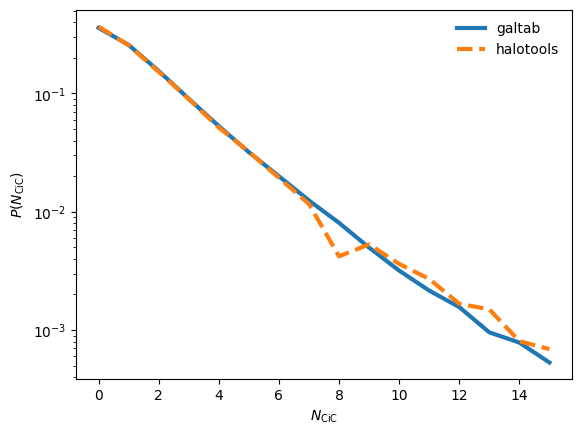

In [4]:
cic_cens = 0.5 * (cic_edges[:-1] + cic_edges[1:])
plt.semilogy(cic_cens, cic_galtab, label="galtab", lw=3)
plt.semilogy(cic_cens, cic_halotools, label="halotools", lw=3, ls="--")
plt.legend(frameon=False)
plt.xlabel("$N_{\\rm CiC}$")
plt.ylabel("$P(N_{\\rm CiC})$")
plt.show()

## **In Development:** Differentiate CiC w.r.t. the HOD parameter $\log M_{\rm min}$

`galtab` is implemented in JAX, so it is portable to GPU and differentiable
(in principal), assuming your HOD model is compatible with JAX. Unfortunately,
this requires a few modifications to `halotools` models. For example, let's
use the `JaxZheng07Cens` and `JaxZheng07Sats` models, originally implemented
for the [JaxTabCorr](https://github.com/AlanPearl/JaxTabCorr) project.

We can construct a composite HOD model with our JAX-compatible mean
occupation functions, which we call `hod_jax`. This model allows us to
differentiate `cictab.predict` with `jax.grad`.

*Note:* You shouldn't try using `jax.jit` directly on `cictab.predict`, since it
contains some I/O lines that can't be compiled. Rest assured that the primary
expensive computations will automatically compile and run on the GPU if available.

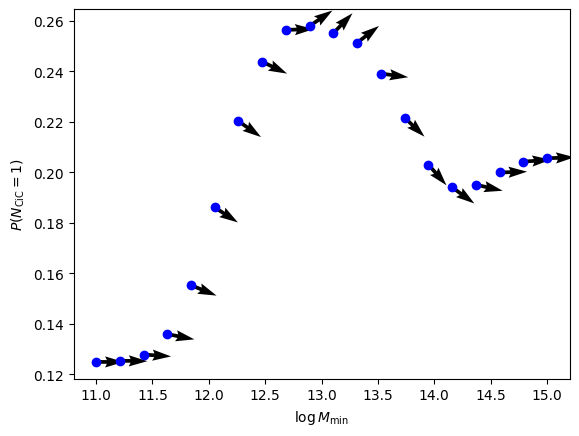

In [5]:
from galtab.jaxhalotools import JaxZheng07Cens, JaxZheng07Sats

# Create JAX-compatible composite HOD model
hod_jax = htem.HodModelFactory(
    centrals_occupation=JaxZheng07Cens(threshold=-21),
    satellites_occupation=JaxZheng07Sats(threshold=-21),
    centrals_profile=htem.TrivialPhaseSpace(),
    satellites_profile=htem.NFWPhaseSpace()
)

# Define function that predictions P(N_cic = 1)
def calc_cic1(logMmin=12.79):
    hod_jax.param_dict.update({"logMmin": logMmin})
    return cictab.predict(hod_jax, warn_p_over_1=False)[1]

# Define the derivative of calc_cic1
diff_cic1 = jax.grad(calc_cic1)

# Note that we shouldn't make logMmin too much lower than that of our fiducial
# model. If desired, make more conservative choices for the fiducial parameters.
# i.e., low logMmin / logM1 / logM0 values and large sigma_logM values
for logmmin in np.linspace(11.0, 15.0, 20):
    value = calc_cic1(logmmin)
    derivative = diff_cic1(logmmin)

    plt.plot(logmmin, value, "bo")
    plt.quiver(logmmin, value, 1, derivative, angles="xy")

plt.xlabel("$\\log M_{\\rm min}$")
plt.ylabel("$P(N_{\\rm CiC} = 1)$")
plt.show()

## `jax.grad` (the arrows in the above plot) isn't working *yet*...

- I actually wasn't expecting the above to work perfectly, because it's using the Monte-Carlo mode, which isn't perfectly continuous
- But analytic mode moment derivatives aren't working either...
- TODO: Figure out what's going wrong